In [1]:
import requests

In [3]:
import math
import time

interval = 86400
resolution = 86400
block_size = 5000
last_block = math.floor(time.time() / interval / 5000)

In [4]:
candles = []
current_block = last_block
current_symbol = "UNICORN:US:AAPL"
while True:

    r = requests.get(f'http://localhost:9702/market/{current_symbol}?segment={current_block}&interval={resolution}')
    if r.status_code == 404:
        break
    elif r.status_code != 200:
        print("something went wrong")
        break

    data = r.json()
    candles = data['candles'] + candles

    current_block -= 1

len(candles)

20000

In [5]:
r = requests.get(
    f"http://localhost:9706/algorithms/double-top/symbols/{current_symbol}?resolution={resolution}&params=7")
data = r.json()
double_top_events = data["events"]
len(double_top_events)

45

In [6]:
r = requests.get(
    f"http://localhost:9706/algorithms/double-bottom/symbols/{current_symbol}?resolution={resolution}&params=7")
data = r.json()
double_bottom_events = data["events"]
len(double_top_events)

45

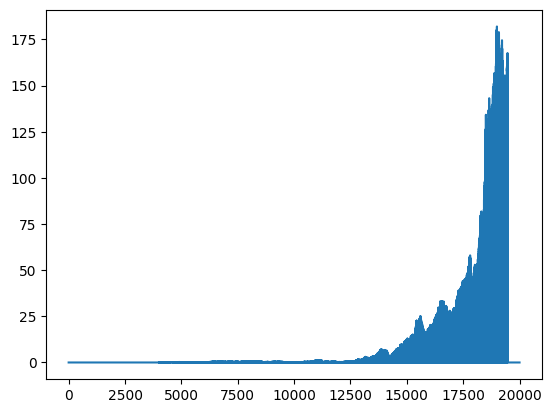

In [7]:
import matplotlib.pyplot as plt

plt.plot([candle['c'] for candle in candles])

In [8]:
def plot_events(events, exit_factor=0.025, timeout_length=14):
    wins = 0
    losses = 0
    timeouts = 0

    for event in events:

        barrier_start = event['annotations']['segments'][0]['timeEnd']

        start_candle = None
        history = []
        is_win = False
        is_loss = False
        is_even = False
        for candle in candles:
            if candle['m']:
                continue
            if candle['t'] == barrier_start:
                if candle['m']:
                    print("something is wrong here")
                start_candle = candle
            if start_candle is not None:
                start_price = start_candle['c']
                current_low = candle['l']
                if len(history) == timeout_length:
                    is_even = True
                    timeouts += 1
                    break
                history.append(candle['c'] / start_price)
                if current_low < start_price / (1.0 + exit_factor):
                    is_loss = True
                    losses += 1
                    break
                current_high = candle['h']
                if current_high > start_price * (1.0 + exit_factor):
                    is_win = True
                    wins += 1
                    break

        if is_win:
            plt.plot(history, color='green')
        if is_loss:
            plt.plot(history, color='red')
        if is_even:
            plt.plot(history, color='orange')

    plt.show()
    print(f"{wins} up | {losses} down | {timeouts} expired")

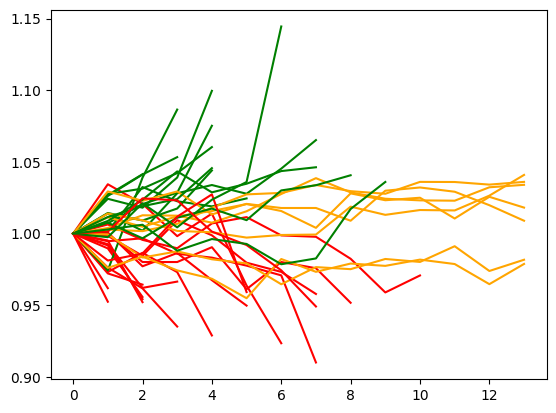

20 up | 18 down | 7 expired
double top: we expect up


In [9]:
plot_events(double_top_events, 0.05, 14)
print("double top: we expect up")

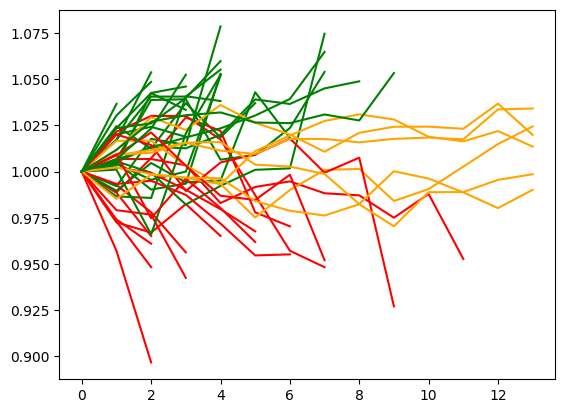

21 up | 19 down | 6 expired
double bottom: we expect down


In [10]:
plot_events(double_bottom_events, 0.05, 14)
print("double bottom: we expect down")

In [11]:
r = requests.get("http://localhost:9702/market/info")
data = r.json()

symbols = []
for ex in data['exchanges']:
    if ex['name'] != "USA Stocks":
        continue
    for s in ex['symbols']:
        symbols.append(s)

print(f"{len(symbols)} symbols")

570 symbols


In [12]:
def fetch_events_and_candles(symbol, algorithm_id):
    candles = []
    current_block = last_block
    while True:

        r = requests.get(f'http://localhost:9702/market/{symbol}?segment={current_block}&interval={resolution}')
        if r.status_code == 404:
            break
        elif r.status_code != 200:
            print("something went wrong")
            break

        data = r.json()
        candles = data['candles'] + candles

        current_block -= 1

    r = requests.get(
        f"http://localhost:9706/algorithms/{algorithm_id}/symbols/{symbol}?resolution={resolution}&params=7")
    data = r.json()
    return candles, data["events"]

In [13]:
def aggregate_events(events,candles, exit_factor=0.025, timeout_length=14):
    wins = 0
    losses = 0
    timeouts = 0

    for event in events:

        barrier_start = event['annotations']['segments'][0]['timeEnd']

        start_candle = None
        history = []
        for candle in candles:
            if candle['m']:
                continue
            if candle['t'] == barrier_start:
                if candle['m']:
                    print("something is wrong here")
                start_candle = candle
            if start_candle is not None:
                start_price = start_candle['c']
                current_low = candle['l']
                if len(history) == timeout_length:
                    timeouts += 1
                    break
                history.append(candle['c'] / start_price)
                if current_low < start_price / (1.0 + exit_factor):
                    losses += 1
                    break
                current_high = candle['h']
                if current_high > start_price * (1.0 + exit_factor):
                    wins += 1
                    break

    return wins, losses, timeouts

In [14]:
total_wins = 0
total_losses=  0
total_evens = 0
for symbol in symbols[:20]:
    print(symbol)
    candles, events = fetch_events_and_candles(symbol, "double-bottom")
    w,l,e = aggregate_events(events, candles, 0.025, 14)
    total_wins+=w
    total_losses+=l
    total_evens+=e
    print(f"{total_wins} up | {total_losses} down | {total_evens} expired")

UNICORN:US:A
18 up | 16 down | 2 expired
UNICORN:US:AAPL
37 up | 42 down | 3 expired
UNICORN:US:ABB
56 up | 62 down | 5 expired
UNICORN:US:ABC
71 up | 82 down | 6 expired
UNICORN:US:ABEV
82 up | 93 down | 6 expired
UNICORN:US:ABMD
87 up | 113 down | 6 expired
UNICORN:US:ABT
114 up | 158 down | 11 expired
UNICORN:US:ACGL
130 up | 184 down | 15 expired
UNICORN:US:ACIW
142 up | 204 down | 15 expired
UNICORN:US:ACN
159 up | 216 down | 17 expired
UNICORN:US:ADI
179 up | 246 down | 17 expired
UNICORN:US:ADP
204 up | 293 down | 22 expired
UNICORN:US:AEE
229 up | 323 down | 34 expired
UNICORN:US:AEG
254 up | 340 down | 34 expired
UNICORN:US:AEM
263 up | 367 down | 34 expired
UNICORN:US:AEP
307 up | 402 down | 50 expired
UNICORN:US:AES
319 up | 424 down | 51 expired
UNICORN:US:AFG
345 up | 460 down | 57 expired
UNICORN:US:AFL
364 up | 489 down | 65 expired
UNICORN:US:AGCO
373 up | 506 down | 66 expired


In [15]:
total_wins = 0
total_losses=  0
total_evens = 0
for symbol in symbols[:20]:
    print(symbol)
    candles, events = fetch_events_and_candles(symbol, "double-top")
    w,l,e = aggregate_events(events, candles, 0.025, 14)
    total_wins+=w
    total_losses+=l
    total_evens+=e
    print(f"{total_wins} up | {total_losses} down | {total_evens} expired")

UNICORN:US:A
19 up | 16 down | 0 expired
UNICORN:US:AAPL
47 up | 33 down | 0 expired
UNICORN:US:ABB
64 up | 47 down | 2 expired
UNICORN:US:ABC
81 up | 63 down | 2 expired
UNICORN:US:ABEV
94 up | 75 down | 2 expired
UNICORN:US:ABMD
105 up | 85 down | 2 expired
UNICORN:US:ABT
141 up | 111 down | 3 expired
UNICORN:US:ACGL
158 up | 127 down | 7 expired
UNICORN:US:ACIW
171 up | 138 down | 7 expired
UNICORN:US:ACN
192 up | 156 down | 8 expired
UNICORN:US:ADI
217 up | 175 down | 9 expired
UNICORN:US:ADP
264 up | 207 down | 15 expired
UNICORN:US:AEE
294 up | 231 down | 24 expired
UNICORN:US:AEG
322 up | 259 down | 27 expired
UNICORN:US:AEM
335 up | 265 down | 27 expired
UNICORN:US:AEP
371 up | 298 down | 40 expired
UNICORN:US:AES
388 up | 314 down | 40 expired
UNICORN:US:AFG
417 up | 340 down | 46 expired
UNICORN:US:AFL
452 up | 361 down | 54 expired
UNICORN:US:AGCO
471 up | 373 down | 54 expired


In [16]:
total_wins = 0
total_losses=  0
total_evens = 0
for symbol in symbols[:20]:
    print(symbol)
    candles, events = fetch_events_and_candles(symbol, "double-bottom")
    w,l,e = aggregate_events(events, candles, 0.05, 14)
    total_wins+=w
    total_losses+=l
    total_evens+=e
    print(f"{total_wins} up | {total_losses} down | {total_evens} expired")

UNICORN:US:A
14 up | 7 down | 15 expired
UNICORN:US:AAPL
35 up | 26 down | 21 expired
UNICORN:US:ABB
49 up | 37 down | 37 expired
UNICORN:US:ABC
60 up | 46 down | 53 expired
UNICORN:US:ABEV
70 up | 55 down | 56 expired
UNICORN:US:ABMD
79 up | 68 down | 59 expired
UNICORN:US:ABT
104 up | 86 down | 93 expired
UNICORN:US:ACGL
115 up | 96 down | 118 expired
UNICORN:US:ACIW
129 up | 111 down | 121 expired
UNICORN:US:ACN
139 up | 117 down | 136 expired
UNICORN:US:ADI
163 up | 136 down | 143 expired
UNICORN:US:ADP
182 up | 162 down | 175 expired
UNICORN:US:AEE
187 up | 174 down | 225 expired
UNICORN:US:AEG
205 up | 190 down | 232 expired
UNICORN:US:AEM
221 up | 208 down | 234 expired
UNICORN:US:AEP
239 up | 220 down | 299 expired
UNICORN:US:AES
248 up | 235 down | 310 expired
UNICORN:US:AFG
257 up | 246 down | 357 expired
UNICORN:US:AFL
276 up | 263 down | 377 expired
UNICORN:US:AGCO
289 up | 273 down | 381 expired


In [17]:
total_wins = 0
total_losses=  0
total_evens = 0
for symbol in symbols[:20]:
    print(symbol)
    candles, events = fetch_events_and_candles(symbol, "double-top")
    w,l,e = aggregate_events(events, candles, 0.05, 14)
    total_wins+=w
    total_losses+=l
    total_evens+=e
    print(f"{total_wins} up | {total_losses} down | {total_evens} expired")

UNICORN:US:A
12 up | 17 down | 6 expired
UNICORN:US:AAPL
32 up | 35 down | 13 expired
UNICORN:US:ABB
44 up | 45 down | 24 expired
UNICORN:US:ABC
54 up | 55 down | 37 expired
UNICORN:US:ABEV
64 up | 65 down | 42 expired
UNICORN:US:ABMD
75 up | 75 down | 42 expired
UNICORN:US:ABT
95 up | 98 down | 62 expired
UNICORN:US:ACGL
106 up | 102 down | 84 expired
UNICORN:US:ACIW
117 up | 112 down | 87 expired
UNICORN:US:ACN
129 up | 124 down | 103 expired
UNICORN:US:ADI
142 up | 145 down | 114 expired
UNICORN:US:ADP
170 up | 171 down | 145 expired
UNICORN:US:AEE
180 up | 190 down | 179 expired
UNICORN:US:AEG
206 up | 207 down | 195 expired
UNICORN:US:AEM
218 up | 214 down | 195 expired
UNICORN:US:AEP
230 up | 234 down | 245 expired
UNICORN:US:AES
242 up | 248 down | 252 expired
UNICORN:US:AFG
251 up | 262 down | 290 expired
UNICORN:US:AFL
268 up | 279 down | 320 expired
UNICORN:US:AGCO
280 up | 292 down | 326 expired
